In [2]:
import pandas as pd
import seaborn as sns
import datetime
import numpy as np

from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()
pd.set_option('display.max_columns', None)

In [3]:
covid_indicator = pd.read_csv('data/table-indicateurs-open-data-france-2022-08-05-19h01.csv')
covid_test = pd.read_csv('data/sp-fra-jour-2022-08-05-19h01.csv', sep=';')

In [4]:
covid_indicator

,date,tx_pos,tx_incid,TO,R,rea,hosp,rad,dchosp,incid_rea,incid_hosp,incid_rad,incid_dchosp,conf,conf_j1,pos,esms_dc,dc_tot,pos_7j,cv_dose1,esms_cas
0,2020-01-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
921,2022-08-01,22.71,421.17,0.238236,NaN,1205.0,20063.0,713025.0,123157.0,130.0,1195.0,1046.0,122.0,NaN,7249.0,56657.0,29022.0,152179.0,285823.0,NaN,402595.0
922,2022-08-02,22.21,392.00,0.233294,NaN,1180.0,19792.0,714464.0,123258.0,141.0,1306.0,1453.0,104.0,NaN,54519.0,36763.0,29022.0,152280.0,266022.0,NaN,402615.0
923,2022-08-03,NaN,NaN,0.227560,NaN,1151.0,19389.0,715761.0,123341.0,92.0,1001.0,1316.0,86.0,NaN,38788.0,NaN,29029.0,152370.0,NaN,NaN,403320.0
924,2022-08-04,NaN,NaN,0.227560,NaN,1151.0,19154.0,716889.0,123426.0,107.0,1002.0,1145.0,87.0,NaN,33799.0,NaN,29031.0,152457.0,NaN,80.3,403749.0


<AxesSubplot:ylabel='date'>

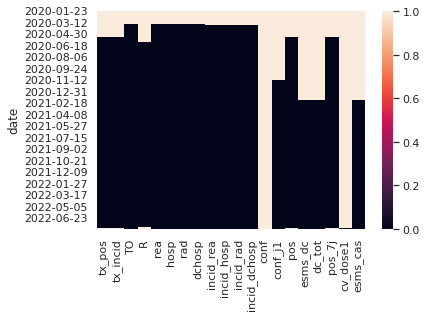

In [5]:
sns.heatmap(covid_indicator.set_index('date').isna())

In [6]:
features = ['hosp', 
        'incid_hosp', 
        'rea', 
        'incid_rea', 
        'rad', 
        'incid_rad',
        'pos',
        'pos_7j',
        'tx_pos',
        'tx_incid',
        'TO',
        'R']

features += ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']

target = ['incid_dchosp']

<AxesSubplot:ylabel='date'>

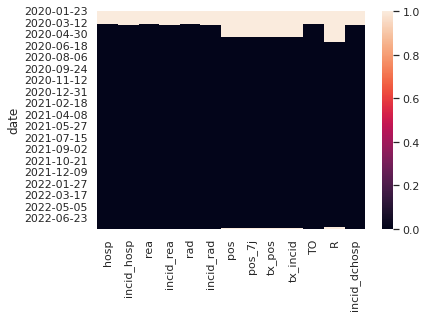

In [7]:
sns.heatmap(covid_indicator.set_index('date')[features + target].isna())

In [40]:
covid_test.loc[:, ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']] = covid_test.loc[:, ['pop', 'P', 'T', 'Ti', 'Tp', 'Td']].applymap(lambda row: float(row.replace(',','.')))

In [60]:
covid_df = pd.merge(
        left=covid_indicator,
        right=covid_test,
        left_on='date',
        right_on='jour',
        how='inner')

covid_df = covid_df[['date'] + features + target].dropna()



In [61]:
def get_j7_dc(row):
    try:
        j7_date = datetime.datetime.strftime(datetime.datetime.strptime(row['date'], '%Y-%m-%d') + datetime.timedelta(days=7), '%Y-%m-%d')
        j7_dc = covid_df.loc[covid_df.date == j7_date, 'incid_dchosp'].values[0]
        return(j7_dc)
    except:
        return(-1)
covid_df.loc[:, 'dc_j7'] = covid_df.apply(get_j7_dc, axis=1)

In [63]:
covid_df = covid_df.loc[covid_df.dc_j7 != -1, :]
covid_df.set_index('date', inplace=True)

In [65]:
df_train, df_val = covid_df.iloc[:-7], covid_df.iloc[-7:]

X_train, y_train = df_train[features], df_train['dc_j7']
X_val, y_val = df_val[features], df_val['dc_j7']


In [66]:
rf = RandomForestRegressor(random_state=0)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_val)

In [72]:
y_pred = np.round(y_pred)

In [73]:
mae = mean_absolute_error(y_val, y_pred)
mae

13.857142857142858

In [74]:
y_pred

array([ 28., 139., 132., 111., 113., 109.,  68.])

In [75]:
y_val

date
2022-07-17     19.0
2022-07-18    132.0
2022-07-19    119.0
2022-07-20     95.0
2022-07-21    104.0
2022-07-22     82.0
2022-07-23     52.0
Name: dc_j7, dtype: float64

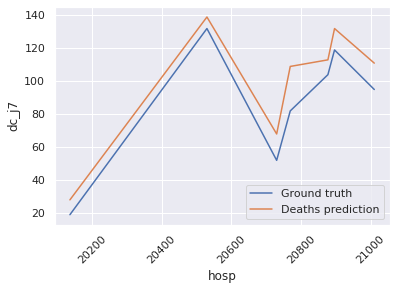

In [76]:
plt.xticks(rotation=45)
sns.lineplot(x=covid_df.iloc[-7:, 0], y=y_val, label='Ground truth')
sns.lineplot(x=covid_df.iloc[-7:, 0], y=y_pred, label='Deaths prediction')
plt.legend()

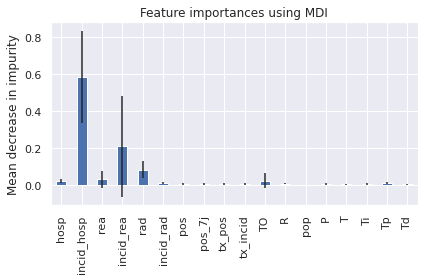

In [77]:
importances = rf.feature_importances_
forest_importances = pd.Series(importances, index=features)
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [78]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_train, y_train, n_repeats=10, random_state=42, n_jobs=2
)


forest_importances = pd.Series(result.importances_mean, index=features)

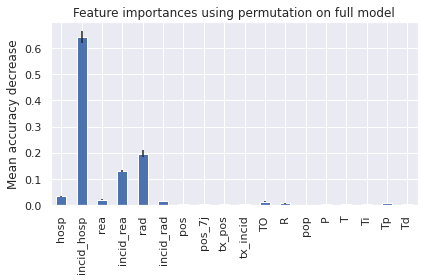

In [79]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()